##**8. Procesamiento de los datos. Features engineering:**

###**8.1. Limpieza de datos:**

No se han detectado filas duplicadas, ni valores nulos o faltantes, ni variables categóricas, por lo que no es necesario realizar ninguna acción para corregir estas problemas.

####**8.1.1. Tratamiento de valores atípicos:**

Durante el análisis exploratorio de los datos, se han detectado valores atípicos en las siguientes variables del dataset.
- Malic_Acid
- Ash
- Ash_Alcanity
- Magnesium
- Proanthocyanins
- Color_Intensity

Para mitigar el impacto de los valores atípicos en el clustering, se probarán diversas técnicas, comparando sus efectos en los datos. Se justifica por la posible distorsión en algoritmos basados en distancia.

**Pruebas a realizar:**

- Reemplazo con la Mediana.
- Regla del Rango Intercuartílico (IQR).
- Método del Z-Score.
- Modified Z-Score.
- Winsorización.

Se crearán copias del DataFrame para cada prueba.

**Visualización y Comparación:**

Tras cada prueba, se compararán los valores de kurtosis y los gráficos de caja resultantes para evaluar el impacto de cada técnica en la distribución y las relaciones entre variables.

**Función Personalizada:**

Finalmente, se creará una función personalizada en Python que aplicará la técnica de tratamiento de atípicos más adecuada a cada variable de forma individual, basándose en los resultados de la comparación. Esto optimizará el preprocesamiento para el análisis de clustering.

In [1]:
# Importar librerías de Python para cargar, procesar, analizar y visualizar los datos.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle

# Nombres de los archivos
nombre_archivo_train = 'train_data_sin_procesar.pkl'

# Descargar el archivo de datos de entrenamiento
with open(nombre_archivo_train, 'rb') as archivo:
    train_data_sin_procesar = pickle.load(archivo)

In [3]:
train_data_sin_procesar.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
# Hago copias del DataFrame para hacer diferentes pruebas y ver qué acción es mejor
train_data_mediana=train_data_sin_procesar.copy()         # Datos a utilizar en la Prueba 1
train_data_iqr=train_data_sin_procesar.copy()             # Datos a utilizar en la Prueba 2
train_data_zscore=train_data_sin_procesar.copy()          # Datos a utilizar en la Prueba 3
train_data_modified_zscore=train_data_sin_procesar.copy() # Datos a utilizar en la Prueba 4
train_data_winsor=train_data_sin_procesar.copy()          # Datos a utilizar en la Prueba 5

In [5]:
# Prueba 1: Reemplazo con el valor de la mediana.

# Calcular los cuartiles y el IQR para cada columna
Q1 = train_data_mediana.quantile(0.25)
Q3 = train_data_mediana.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
mediana_por_columna = train_data_mediana.median()

# Iterar sobre las columnas del DataFrame
for columna in train_data_mediana.columns:
    # Identificar los valores atípicos para la columna actual
    outliers_inferiores = train_data_mediana[columna] < limite_inferior[columna]
    outliers_superiores = train_data_mediana[columna] > limite_superior[columna]

    # Reemplazar los valores atípicos con la mediana de *esa columna*
    train_data_mediana.loc[outliers_inferiores, columna] = mediana_por_columna[columna]
    train_data_mediana.loc[outliers_superiores, columna] = mediana_por_columna[columna]


In [6]:
# Prueba 2: Regla del Rango Intercuartílico (IQR)
# Calcular los cuartiles y el IQR para cada columna
Q1 = train_data_iqr.quantile(0.25)
Q3 = train_data_iqr.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Iterar sobre las columnas del DataFrame
for columna in train_data_iqr.columns:
    # Identificar los valores atípicos para la columna actual
    outliers_inferiores = train_data_iqr[columna] < limite_inferior[columna]
    outliers_superiores = train_data_iqr[columna] > limite_superior[columna]

    # Reemplazar los valores atípicos con los límites
    train_data_iqr.loc[outliers_inferiores, columna] = limite_inferior[columna]
    train_data_iqr.loc[outliers_superiores, columna] = limite_superior[columna]


<ipython-input-6-97bf19655dcb>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '59.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_iqr.loc[outliers_inferiores, columna] = limite_inferior[columna]
<ipython-input-6-97bf19655dcb>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-227.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_iqr.loc[outliers_inferiores, columna] = limite_inferior[columna]


In [7]:
# Prueba 3: Método del Z-Score (Puntuación Estándar)
from scipy import stats

# Definir el umbral del Z-Score para considerar un valor como atípico
umbral_z = 3

# Iterar sobre las columnas del DataFrame
for columna in train_data_zscore.columns:
    # Calcular el Z-Score para cada valor en la columna
    z_scores = np.abs(stats.zscore(train_data_zscore[columna]))

    # Identificar los valores atípicos (donde el valor absoluto del Z-Score excede el umbral)
    es_atipico = z_scores > umbral_z

    # Calcular la mediana de la columna (para el reemplazo)
    mediana_columna = train_data_zscore[columna].median()

    # Reemplazar los valores atípicos con la mediana
    train_data_zscore.loc[es_atipico, columna] = mediana_columna


In [8]:
# Prueba 4: Modified Z-Score (Puntuación Z Modificada)

# Definir el umbral del Modified Z-Score para considerar un valor como atípico
umbral_mod_z = 3.5  # Umbral común para el Modified Z-Score

# Iterar sobre las columnas del DataFrame
for columna in train_data_modified_zscore.columns:
    # Calcular la mediana de la columna
    mediana_columna = train_data_modified_zscore[columna].median()

    # Calcular la desviación absoluta de la mediana (MAD)
    mad_columna = np.median(np.abs(train_data_modified_zscore[columna] - mediana_columna))

    # Evitar la división por cero si MAD es cero (todos los valores son iguales)
    if mad_columna == 0:
        continue

    # Calcular el Modified Z-Score
    modified_z_scores = 0.6745 * (np.abs(train_data_modified_zscore[columna] - mediana_columna) / mad_columna)

    # Identificar los valores atípicos (donde el Modified Z-Score excede el umbral)
    es_atipico = modified_z_scores > umbral_mod_z

    # Calcular la mediana de la columna (para el reemplazo)
    # (Ya se calculó anteriormente, se puede reutilizar)

    # Reemplazar los valores atípicos con la mediana
    train_data_modified_zscore.loc[es_atipico, columna] = mediana_columna

In [9]:
# Prueba 5: Winsorización
from scipy.stats.mstats import winsorize

# Definir el percentil de winsorización (ejemplo: 5% inferior y 5% superior)
percentil_inferior = 0.05
percentil_superior = 0.05

# Iterar sobre las columnas del DataFrame
for columna in train_data_winsor.columns:
    # Aplicar la winsorización a la columna
    winsorized_col = winsorize(train_data_winsor[columna], limits=(percentil_inferior, percentil_superior))

    # Reemplazar la columna original con la versión winsorizada
    train_data_winsor[columna] = winsorized_col

In [10]:
# Creo un diccionario con los dataframes_tratados para poder visualizar mejor los resultados del estudio estadístico
dataframes_tratados = {
    'Mediana': train_data_mediana,
    'IQR': train_data_iqr,
    'ZScore': train_data_zscore,
    'ModifiedZScore': train_data_modified_zscore,
    'Winsorizacion': train_data_winsor
}

# Verifico el contenido del diccionario
print("El diccionario 'dataframes_tratados' contiene los siguientes DataFrames:")
for nombre_prueba, df in dataframes_tratados.items():
    print(f"- {nombre_prueba}: DataFrame con {len(df)} filas y {len(df.columns)} columnas")

El diccionario 'dataframes_tratados' contiene los siguientes DataFrames:
- Mediana: DataFrame con 173 filas y 13 columnas
- IQR: DataFrame con 173 filas y 13 columnas
- ZScore: DataFrame con 173 filas y 13 columnas
- ModifiedZScore: DataFrame con 173 filas y 13 columnas
- Winsorizacion: DataFrame con 173 filas y 13 columnas


In [11]:
# Obtener la lista de variables numéricas del primer DataFrame
primer_df = next(iter(dataframes_tratados.values()))
variables_numericas = primer_df.select_dtypes(include=np.number).columns

# Iterar sobre cada variable numérica y crear una tabla comparativa
for variable in variables_numericas:
    estadisticas = {}
    for nombre_prueba, df in dataframes_tratados.items():
        if variable in df.columns:
            desc = df[variable].describe()
            estadisticas[nombre_prueba] = desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        else:
            print(f"Advertencia: La variable '{variable}' no se encuentra en el DataFrame '{nombre_prueba}'.")

    tabla_comparativa = pd.DataFrame(estadisticas).T
    print(f"\nEstadísticas comparativas para la variable: {variable}")
    print(tabla_comparativa)


Estadísticas comparativas para la variable: Alcohol
                     mean       std    min    25%    50%    75%    max
Mediana         12.989769  0.813504  11.03  12.34  13.05  13.67  14.83
IQR             12.989769  0.813504  11.03  12.34  13.05  13.67  14.83
ZScore          12.989769  0.813504  11.03  12.34  13.05  13.67  14.83
ModifiedZScore  12.989769  0.813504  11.03  12.34  13.05  13.67  14.83
Winsorizacion   12.986994  0.777750  11.65  12.34  13.05  13.67  14.23

Estadísticas comparativas para la variable: Malic_Acid
                    mean       std   min   25%   50%   75%   max
Mediana         2.245896  1.004144  0.74  1.61  1.86  2.89  5.04
IQR             2.322197  1.093835  0.74  1.61  1.86  3.03  5.16
ZScore          2.308150  1.086977  0.74  1.61  1.86  3.03  5.65
ModifiedZScore  2.161387  0.904017  0.74  1.61  1.86  2.59  4.43
Winsorizacion   2.308439  1.044406  1.01  1.61  1.86  3.03  4.60

Estadísticas comparativas para la variable: Ash
                    mean  

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask'

In [12]:
# Calcular la curtosis de cada dataframe después de las transformaciones y asi poder comparar numéricamente.

kurtosis_mediana = train_data_mediana.kurt()
print("\nCurtosis (Kurtosis_mediana) de cada variable:\n", kurtosis_mediana)


Curtosis (Kurtosis_mediana) de cada variable:
 Alcohol                -0.847316
Malic_Acid             -0.088958
Ash                    -0.206544
Ash_Alcanity           -0.008924
Magnesium              -0.089339
Total_Phenols          -0.820529
Flavanoids             -0.862770
Nonflavanoid_Phenols   -0.634791
Proanthocyanins         0.001895
Color_Intensity        -0.182244
Hue                    -0.783624
OD280                  -1.103906
Proline                -0.194714
dtype: float64


In [13]:
kurtosis_iqr = train_data_iqr.kurt()
print("\nCurtosis (Kurtosis_iqr) de cada variable:\n", kurtosis_iqr)


Curtosis (Kurtosis_iqr) de cada variable:
 Alcohol                -0.847316
Malic_Acid             -0.042745
Ash                     0.130526
Ash_Alcanity            0.188081
Magnesium               0.146392
Total_Phenols          -0.820529
Flavanoids             -0.862770
Nonflavanoid_Phenols   -0.634791
Proanthocyanins         0.027882
Color_Intensity        -0.178059
Hue                    -0.545136
OD280                  -1.103906
Proline                -0.194714
dtype: float64


In [14]:
kurtosis_zscore = train_data_zscore.kurt()
print("\nCurtosis (Kurtosis_zscore) de cada variable:\n", kurtosis_zscore)


Curtosis (Kurtosis_zscore) de cada variable:
 Alcohol                -0.847316
Malic_Acid              0.235050
Ash                     0.042588
Ash_Alcanity            0.277440
Magnesium               0.220885
Total_Phenols          -0.820529
Flavanoids             -1.202451
Nonflavanoid_Phenols   -0.634791
Proanthocyanins         0.195896
Color_Intensity        -0.049869
Hue                    -0.783624
OD280                  -1.103906
Proline                -0.194714
dtype: float64


In [15]:
kurtosis_modified_zscore = train_data_modified_zscore.kurt()
print("\nCurtosis (Kurtosis_modified_zscore) de cada variable:\n", kurtosis_modified_zscore)


Curtosis (Kurtosis_modified_zscore) de cada variable:
 Alcohol                -0.847316
Malic_Acid             -0.167142
Ash                     0.042588
Ash_Alcanity            0.476744
Magnesium               0.220885
Total_Phenols          -0.820529
Flavanoids             -0.862770
Nonflavanoid_Phenols   -0.634791
Proanthocyanins         0.195896
Color_Intensity        -0.049869
Hue                    -0.358044
OD280                  -1.103906
Proline                -0.194714
dtype: float64


In [16]:
kurtosis_winsor = train_data_winsor.kurt()
print("\nCurtosis (Kurtosis_winsor) de cada variable:\n", kurtosis_winsor)


Curtosis (Kurtosis_winsor) de cada variable:
 Alcohol                -1.142635
Malic_Acid             -0.474264
Ash                    -0.735269
Ash_Alcanity           -0.789155
Magnesium              -0.582619
Total_Phenols          -1.212651
Flavanoids             -1.294864
Nonflavanoid_Phenols   -0.851900
Proanthocyanins        -0.355794
Color_Intensity        -0.557830
Hue                    -0.973324
OD280                  -1.237296
Proline                -0.825149
dtype: float64


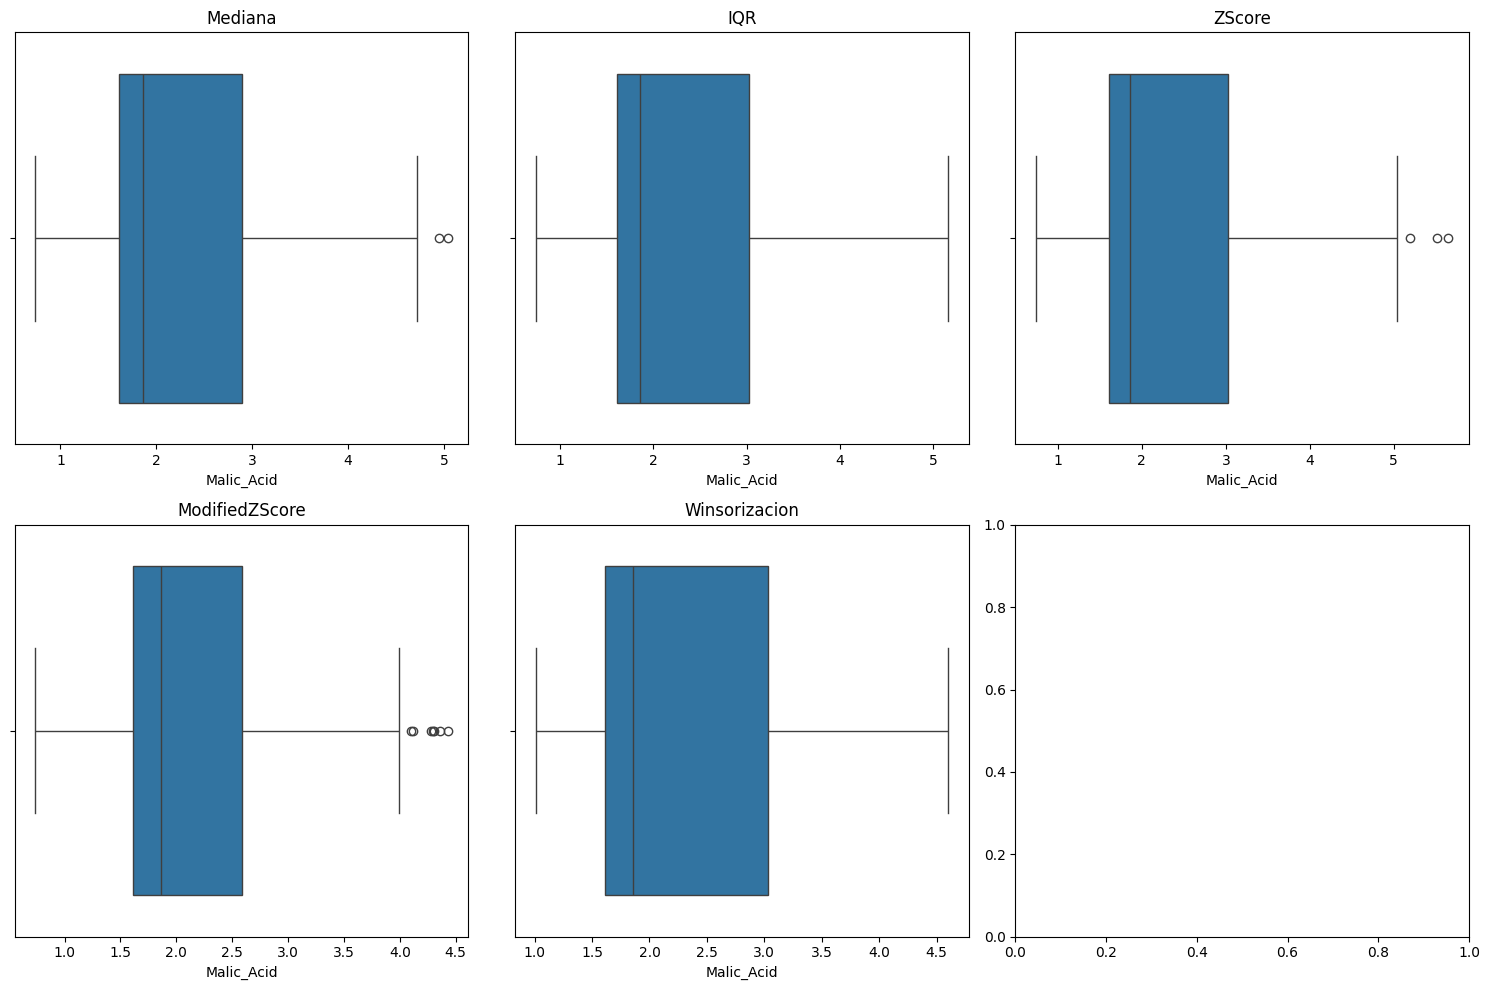

In [26]:
# Variable Malic_Acid
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
methods = ['Mediana', 'IQR', 'ZScore', 'ModifiedZScore', 'Winsorizacion']
dfs = [train_data_mediana, train_data_iqr, train_data_zscore, train_data_modified_zscore, train_data_winsor]  # DataFrames modificados

for i, df_mod in enumerate(dfs):
    sns.boxplot(x=df_mod['Malic_Acid'], ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(methods[i])

plt.tight_layout()
plt.show()

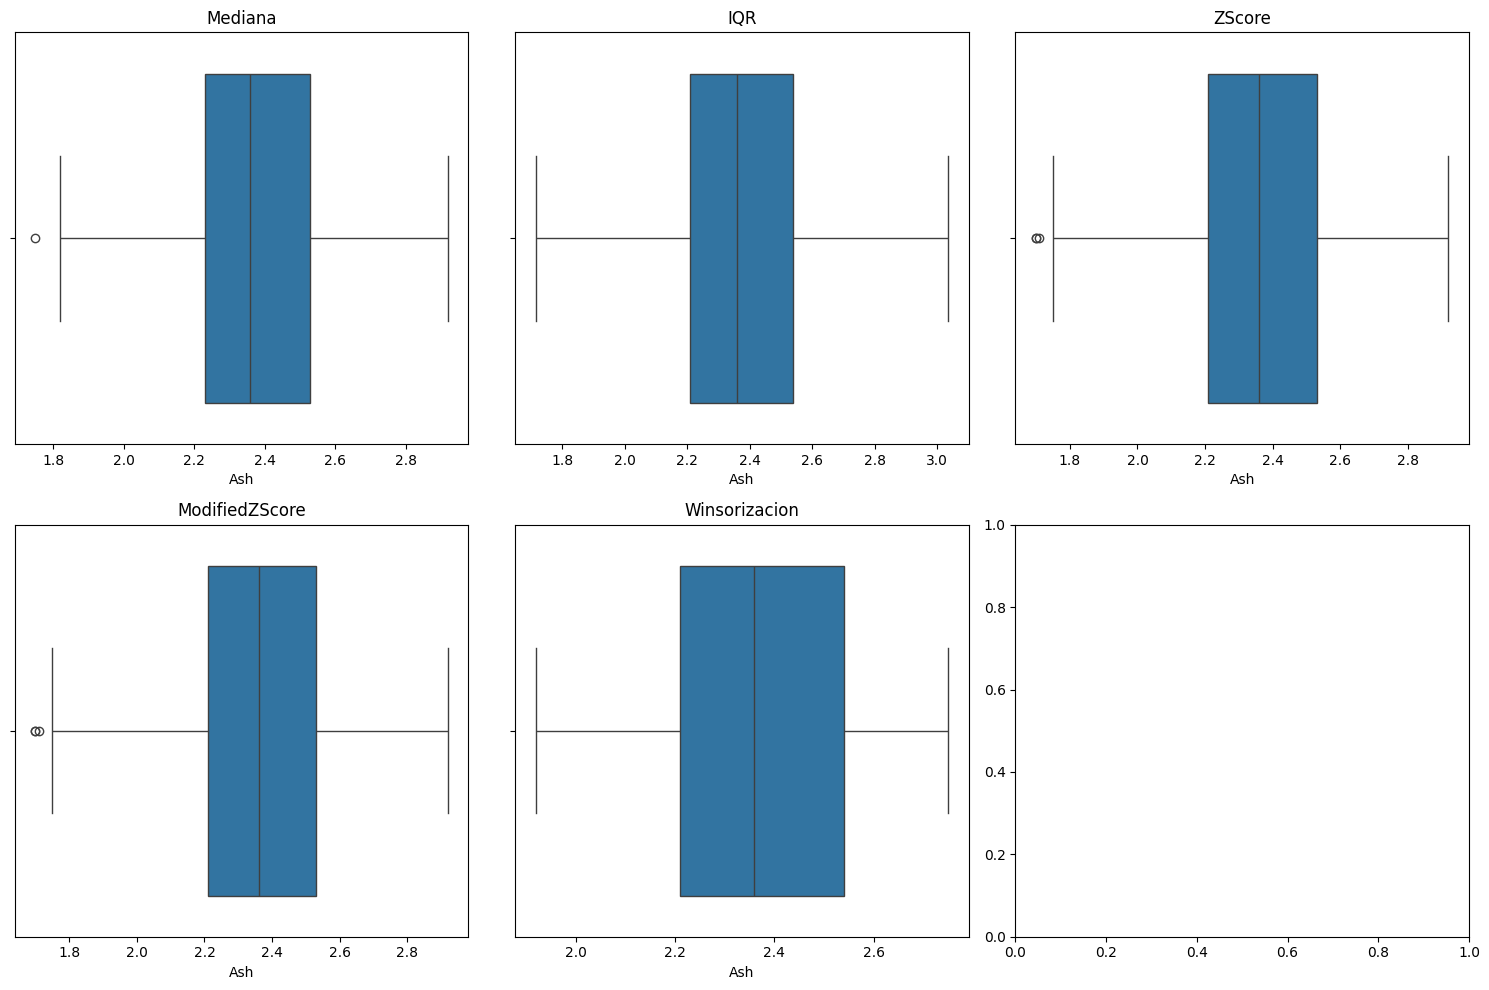

In [27]:
# Variable Ash
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
methods = ['Mediana', 'IQR', 'ZScore', 'ModifiedZScore', 'Winsorizacion']
dfs = [train_data_mediana, train_data_iqr, train_data_zscore, train_data_modified_zscore, train_data_winsor]  # DataFrames modificados

for i, df_mod in enumerate(dfs):
    sns.boxplot(x=df_mod['Ash'], ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(methods[i])

plt.tight_layout()
plt.show()

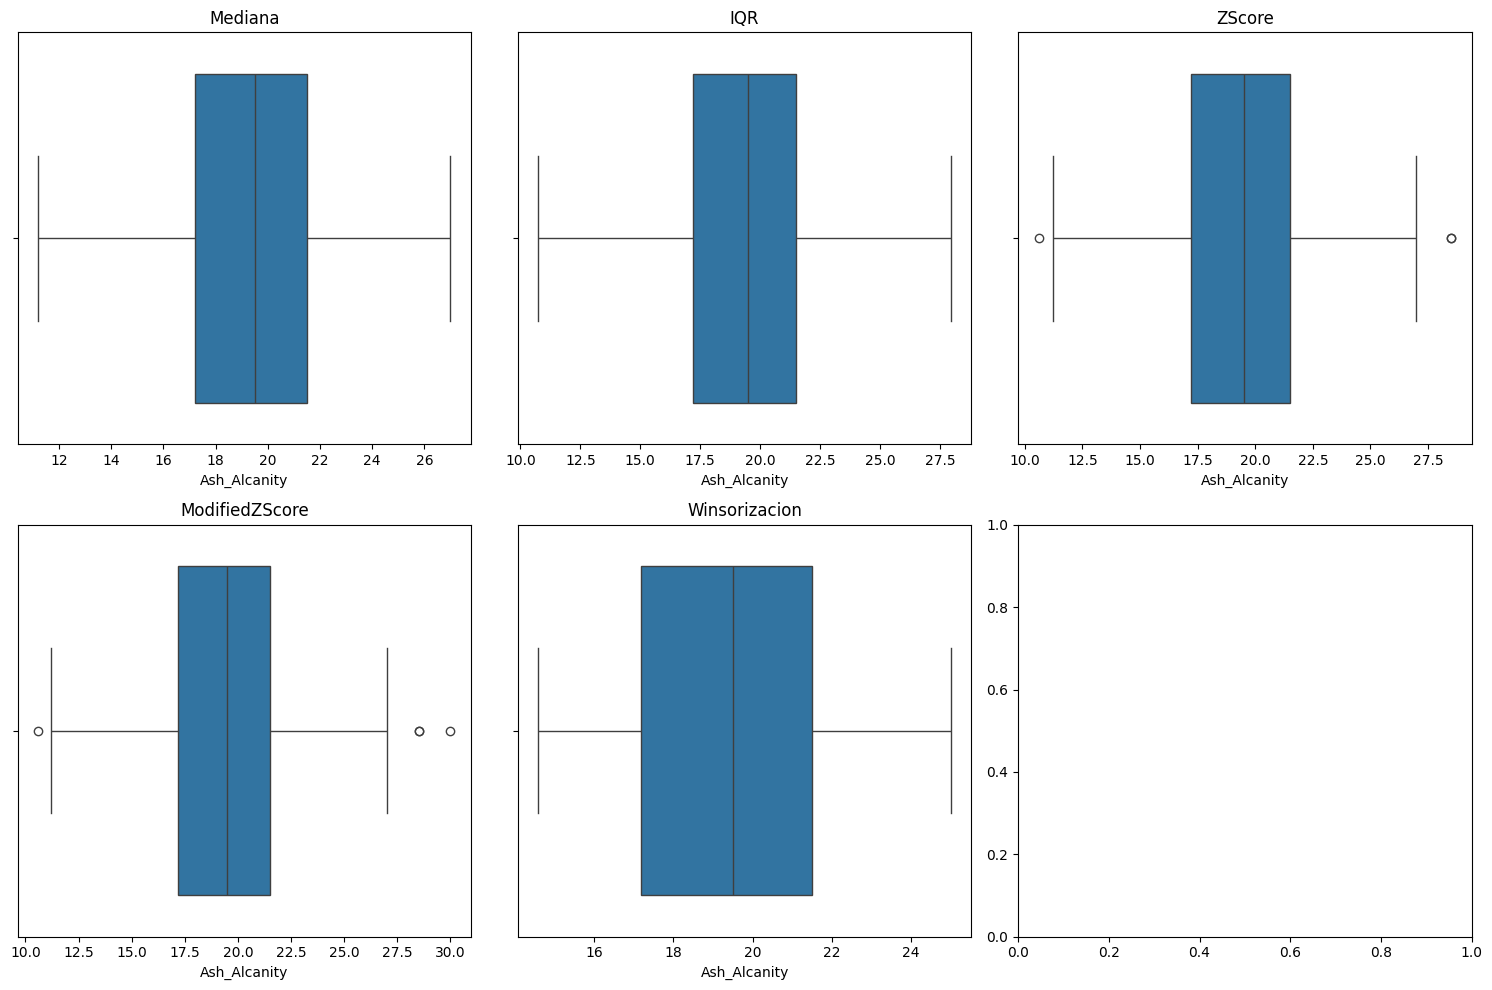

In [29]:
# Variable Ash_Alcanity
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
methods = ['Mediana', 'IQR', 'ZScore', 'ModifiedZScore', 'Winsorizacion']
dfs = [train_data_mediana, train_data_iqr, train_data_zscore, train_data_modified_zscore, train_data_winsor]  # DataFrames modificados

for i, df_mod in enumerate(dfs):
    sns.boxplot(x=df_mod['Ash_Alcanity'], ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(methods[i])

plt.tight_layout()
plt.show()

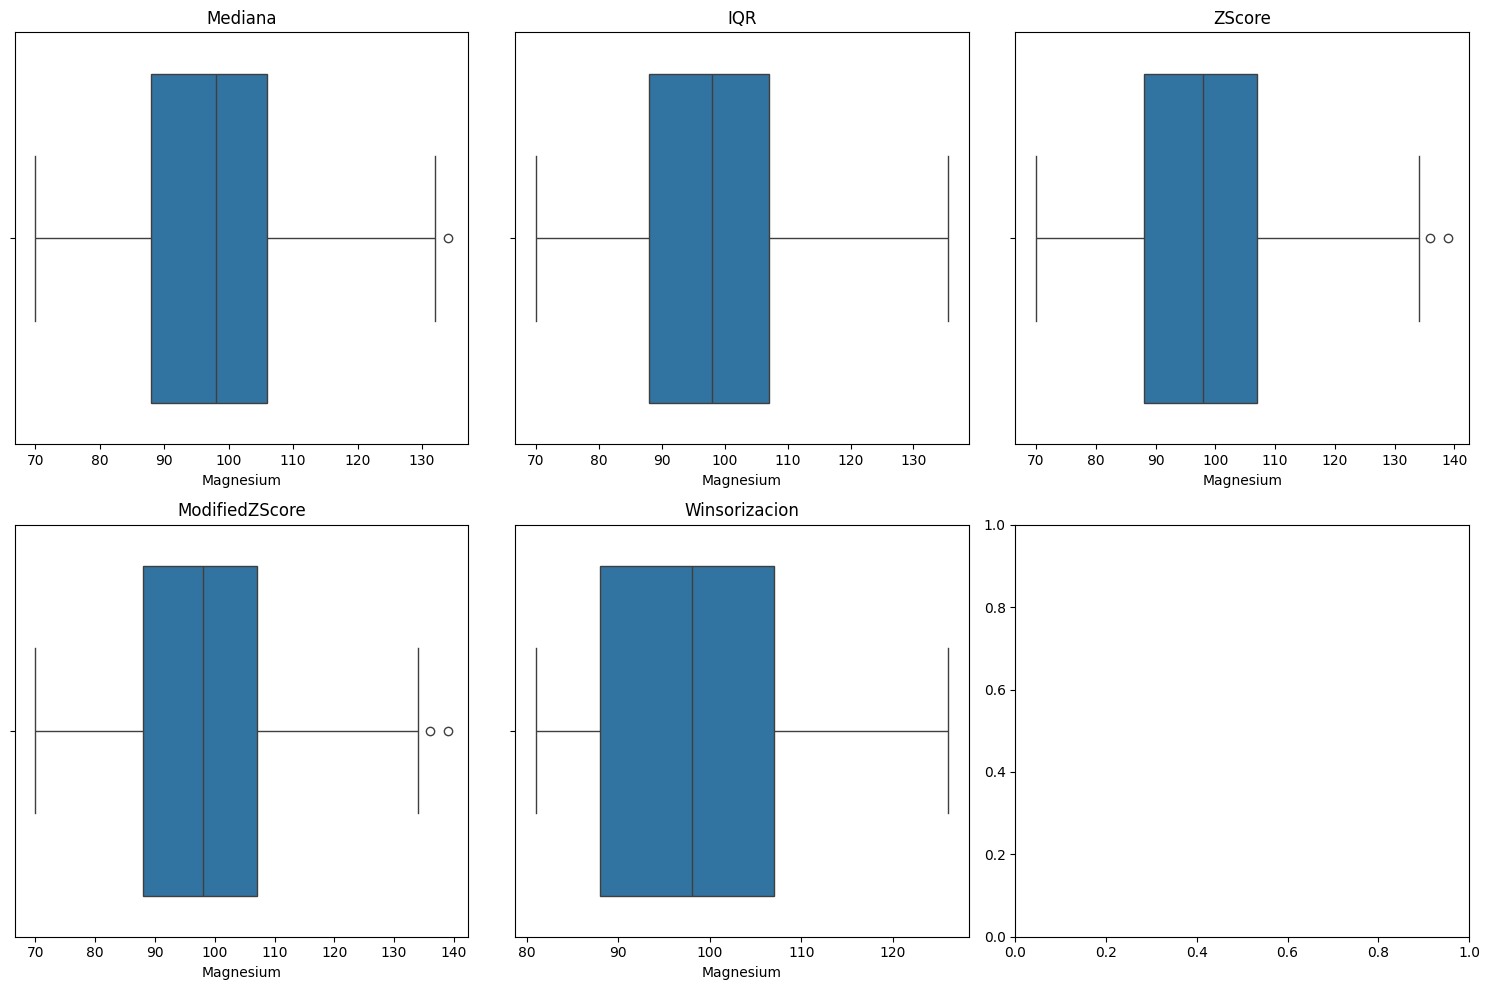

In [30]:
# Variable Magnesium
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
methods = ['Mediana', 'IQR', 'ZScore', 'ModifiedZScore', 'Winsorizacion']
dfs = [train_data_mediana, train_data_iqr, train_data_zscore, train_data_modified_zscore, train_data_winsor]  # DataFrames modificados

for i, df_mod in enumerate(dfs):
    sns.boxplot(x=df_mod['Magnesium'], ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(methods[i])

plt.tight_layout()
plt.show()

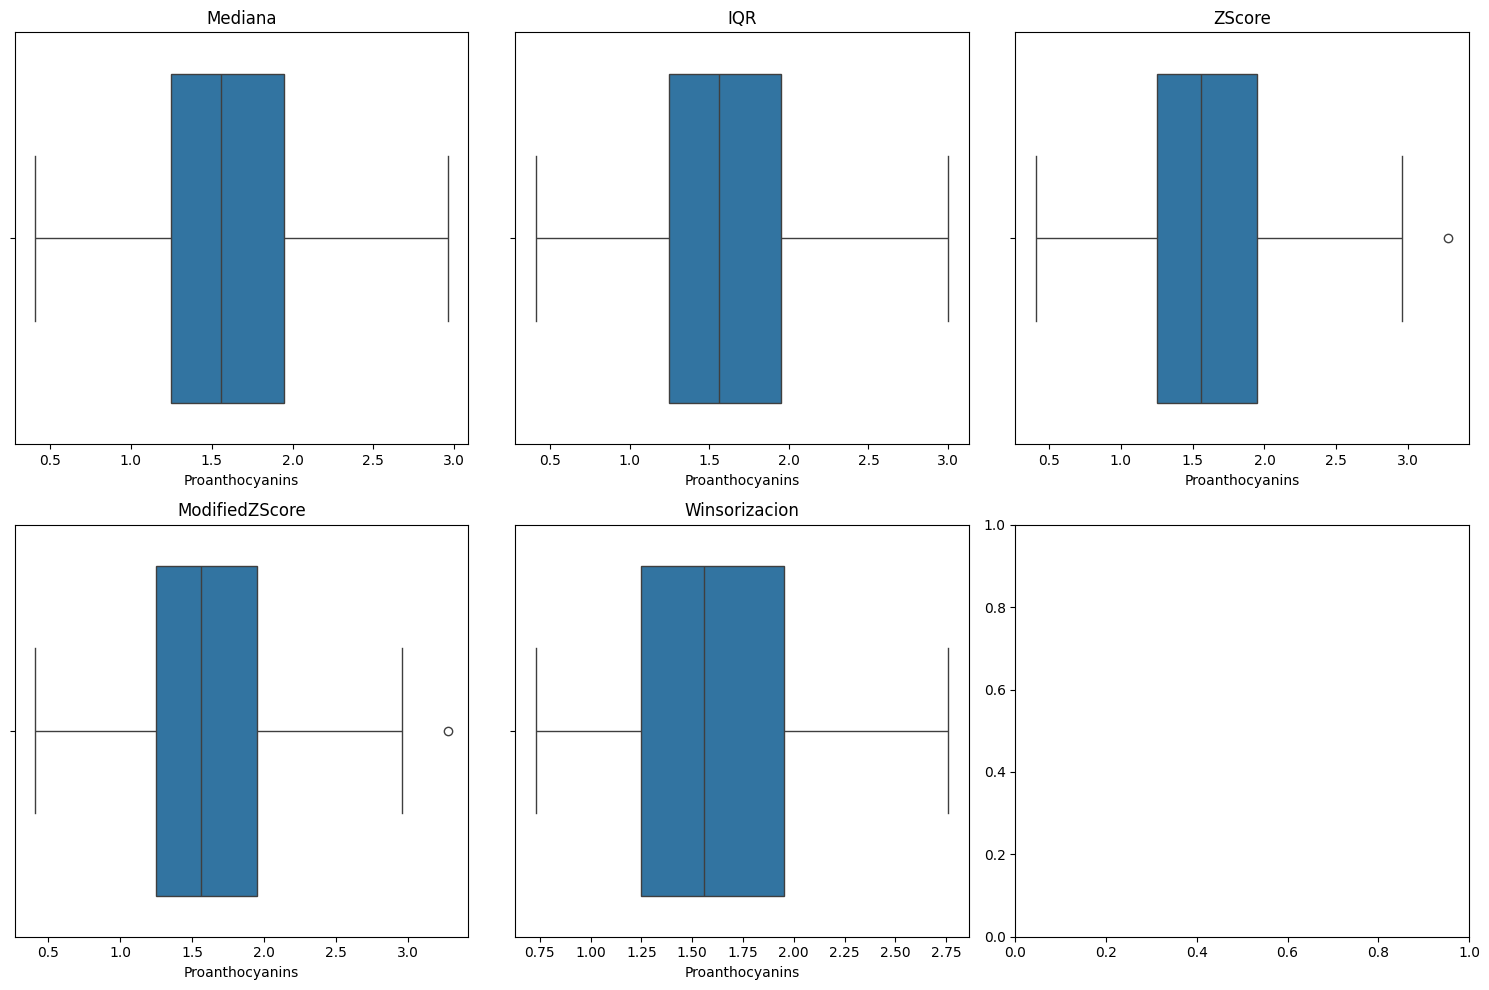

In [31]:
# Variable Proanthocyanins
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
methods = ['Mediana', 'IQR', 'ZScore', 'ModifiedZScore', 'Winsorizacion']
dfs = [train_data_mediana, train_data_iqr, train_data_zscore, train_data_modified_zscore, train_data_winsor]  # DataFrames modificados

for i, df_mod in enumerate(dfs):
    sns.boxplot(x=df_mod['Proanthocyanins'], ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(methods[i])

plt.tight_layout()
plt.show()

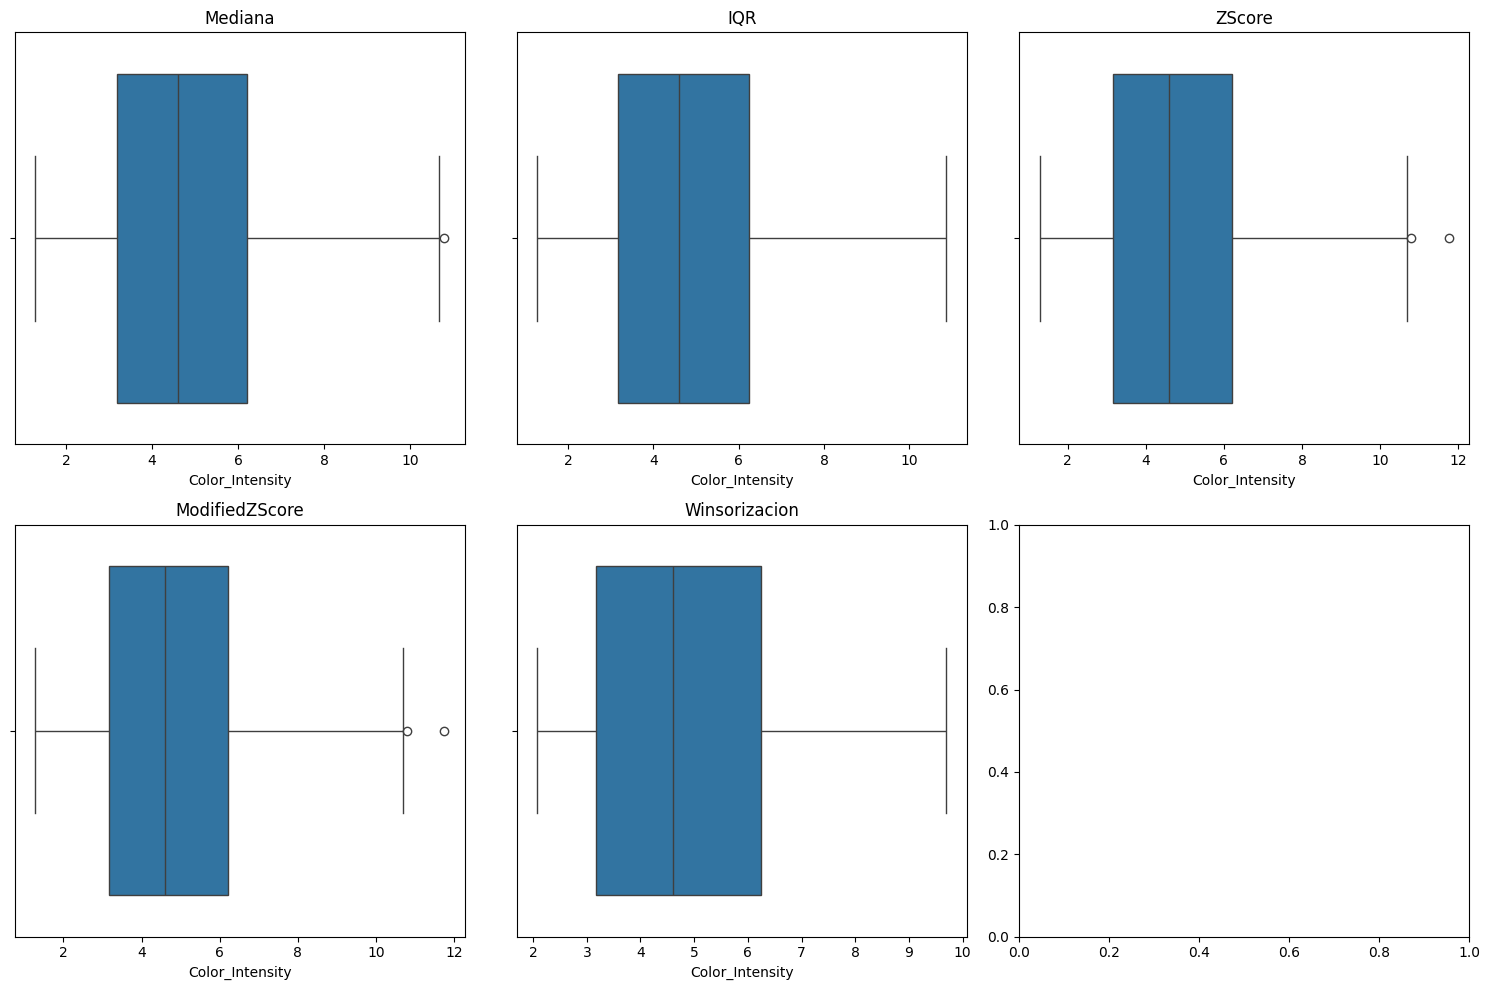

In [32]:
# Variable Color_Intensity
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
methods = ['Mediana', 'IQR', 'ZScore', 'ModifiedZScore', 'Winsorizacion']
dfs = [train_data_mediana, train_data_iqr, train_data_zscore, train_data_modified_zscore, train_data_winsor]  # DataFrames modificados

for i, df_mod in enumerate(dfs):
    sns.boxplot(x=df_mod['Color_Intensity'], ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(methods[i])

plt.tight_layout()
plt.show()

####**8.1.2. Conclusiones del tratamiento de datos atípicos:**

Tras evaluar diversas técnicas para el tratamiento de datos atípicos en las variables Malic_Acid, Ash, Ash_Alcalinity, Magnesium, Proanthocyanins y Proline, obtengo las siguientes conclusiones, considerando los resultados de curtosis obtenidos para cada método:

- La **Regla del Rango Intercuartílico (IQR)** se ha identificado, a través de la inspección gráfica y el análisis de la curtosis, como la técnica más adecuada para abordar los valores atípicos en estas variables. Los resultados de curtosis obtenidos tras la aplicación del IQR mostraron, en general, una tendencia hacia distribuciones más cercanas a la normalidad en comparación con otras técnicas evaluadas. Específicamente:

- Para Malic_Acid, el IQR generó la curtosis más próxima a cero, sugiriendo una forma de distribución más simétrica y con colas menos pesadas en comparación con el reemplazo por la mediana, el método del Z-Score, el Modified Z-Score y la winsorización.
- En el caso de Ash, el IQR arrojó uno de los valores de curtosis más cercanos a cero, similar al obtenido con el reemplazo por la mediana, indicando una distribución con características de normalidad más pronunciadas que las otras técnicas.
- Para Ash_Alcanity, el IQR también demostró ser efectivo al producir una curtosis relativamente cercana a cero, superando los resultados del método Z-Score, Modified Z-Score y la winsorización.
- Si bien para Magnesium la técnica de la mediana arrojó un resultado de curtosis ligeramente más cercano a cero, la diferencia con el resultado obtenido mediante el IQR fue mínima. Dada la consistencia observada en las demás variables y el objetivo de aplicar una metodología uniforme, se justifica la elección del IQR.
- En cuanto a Proanthocyanins, el IQR también generó una curtosis más cercana a cero en comparación con el reemplazo por la mediana, el método Z-Score y la winsorización, aunque el Modified Z-Score mostró un resultado ligeramente mejor. Sin embargo, considerando el rendimiento general del IQR en las otras variables, se mantiene como la opción preferente.
- Finalmente, para Proline, el IQR mostró una curtosis similar al reemplazo por la mediana y superior a las otras técnicas, indicando una preservación de la forma de la distribución más cercana a la normalidad.

Si bien otras técnicas como el reemplazo por la mediana, el método del Z-Score, el Modified Z-Score y la winsorización ofrecieron en algunos casos resultados de curtosis competitivos para variables individuales, la Regla del Rango Intercuartílico (IQR) demostró una consistencia y efectividad general superior en la tarea de mitigar la influencia de los valores atípicos, acercando las distribuciones de las variables seleccionadas a una forma más deseable para el modelado predictivo, sin introducir una distorsión excesiva en los datos. Por esta razón, se va a proceder a implementar la técnica del IQR para el tratamiento de los outliers en las variables Malic_Acid, Ash, Ash_Alcalinity, Magnesium, Proanthocyanins y Proline en nuestros conjuntos de datos de entrenamiento y prueba.

In [35]:
def eliminar_outliers_iqr(df, columna):
    """
    Elimina los outliers de una columna de un DataFrame utilizando la técnica del IQR.

    Args:
        df (pd.DataFrame): DataFrame a procesar.
        columna (str): Nombre de la columna donde se eliminarán los outliers.

    Returns:
        pd.DataFrame: DataFrame con los outliers eliminados.
    """
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_filtrado = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]
    return df_filtrado

# Variables a las que aplicaremos la eliminación de outliers por IQR
variables_a_tratar = ['Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium', 'Proanthocyanins', 'Proline']

# Aplicar la eliminación de outliers al conjunto de entrenamiento
train_data_sin_outliers = train_data_sin_procesar.copy()

for columna in variables_a_tratar:
    train_data_sin_outliers = eliminar_outliers_iqr(train_data_sin_outliers, columna)


In [36]:
train_data_sin_outliers.shape

(157, 13)

###**8.2. Features Engineering:**

Durante el análisis exploratorio, se han identificado algunas variables con sesgos significativos hacia la derecha.

Es fundamental corregir estos sesgos para evitar que afecten negativamente el rendimiento de los modelos de aprendizaje automático, ya que estos pueden ser sensibles a valores extremos y a distribuciones no normales.

Antes de realizar cualquier tratamiento para para corregir el sesgo de las variables que lo posean, se visualizarán los histogramas de todas las variables después de realizar el tratamiento para los outliers.

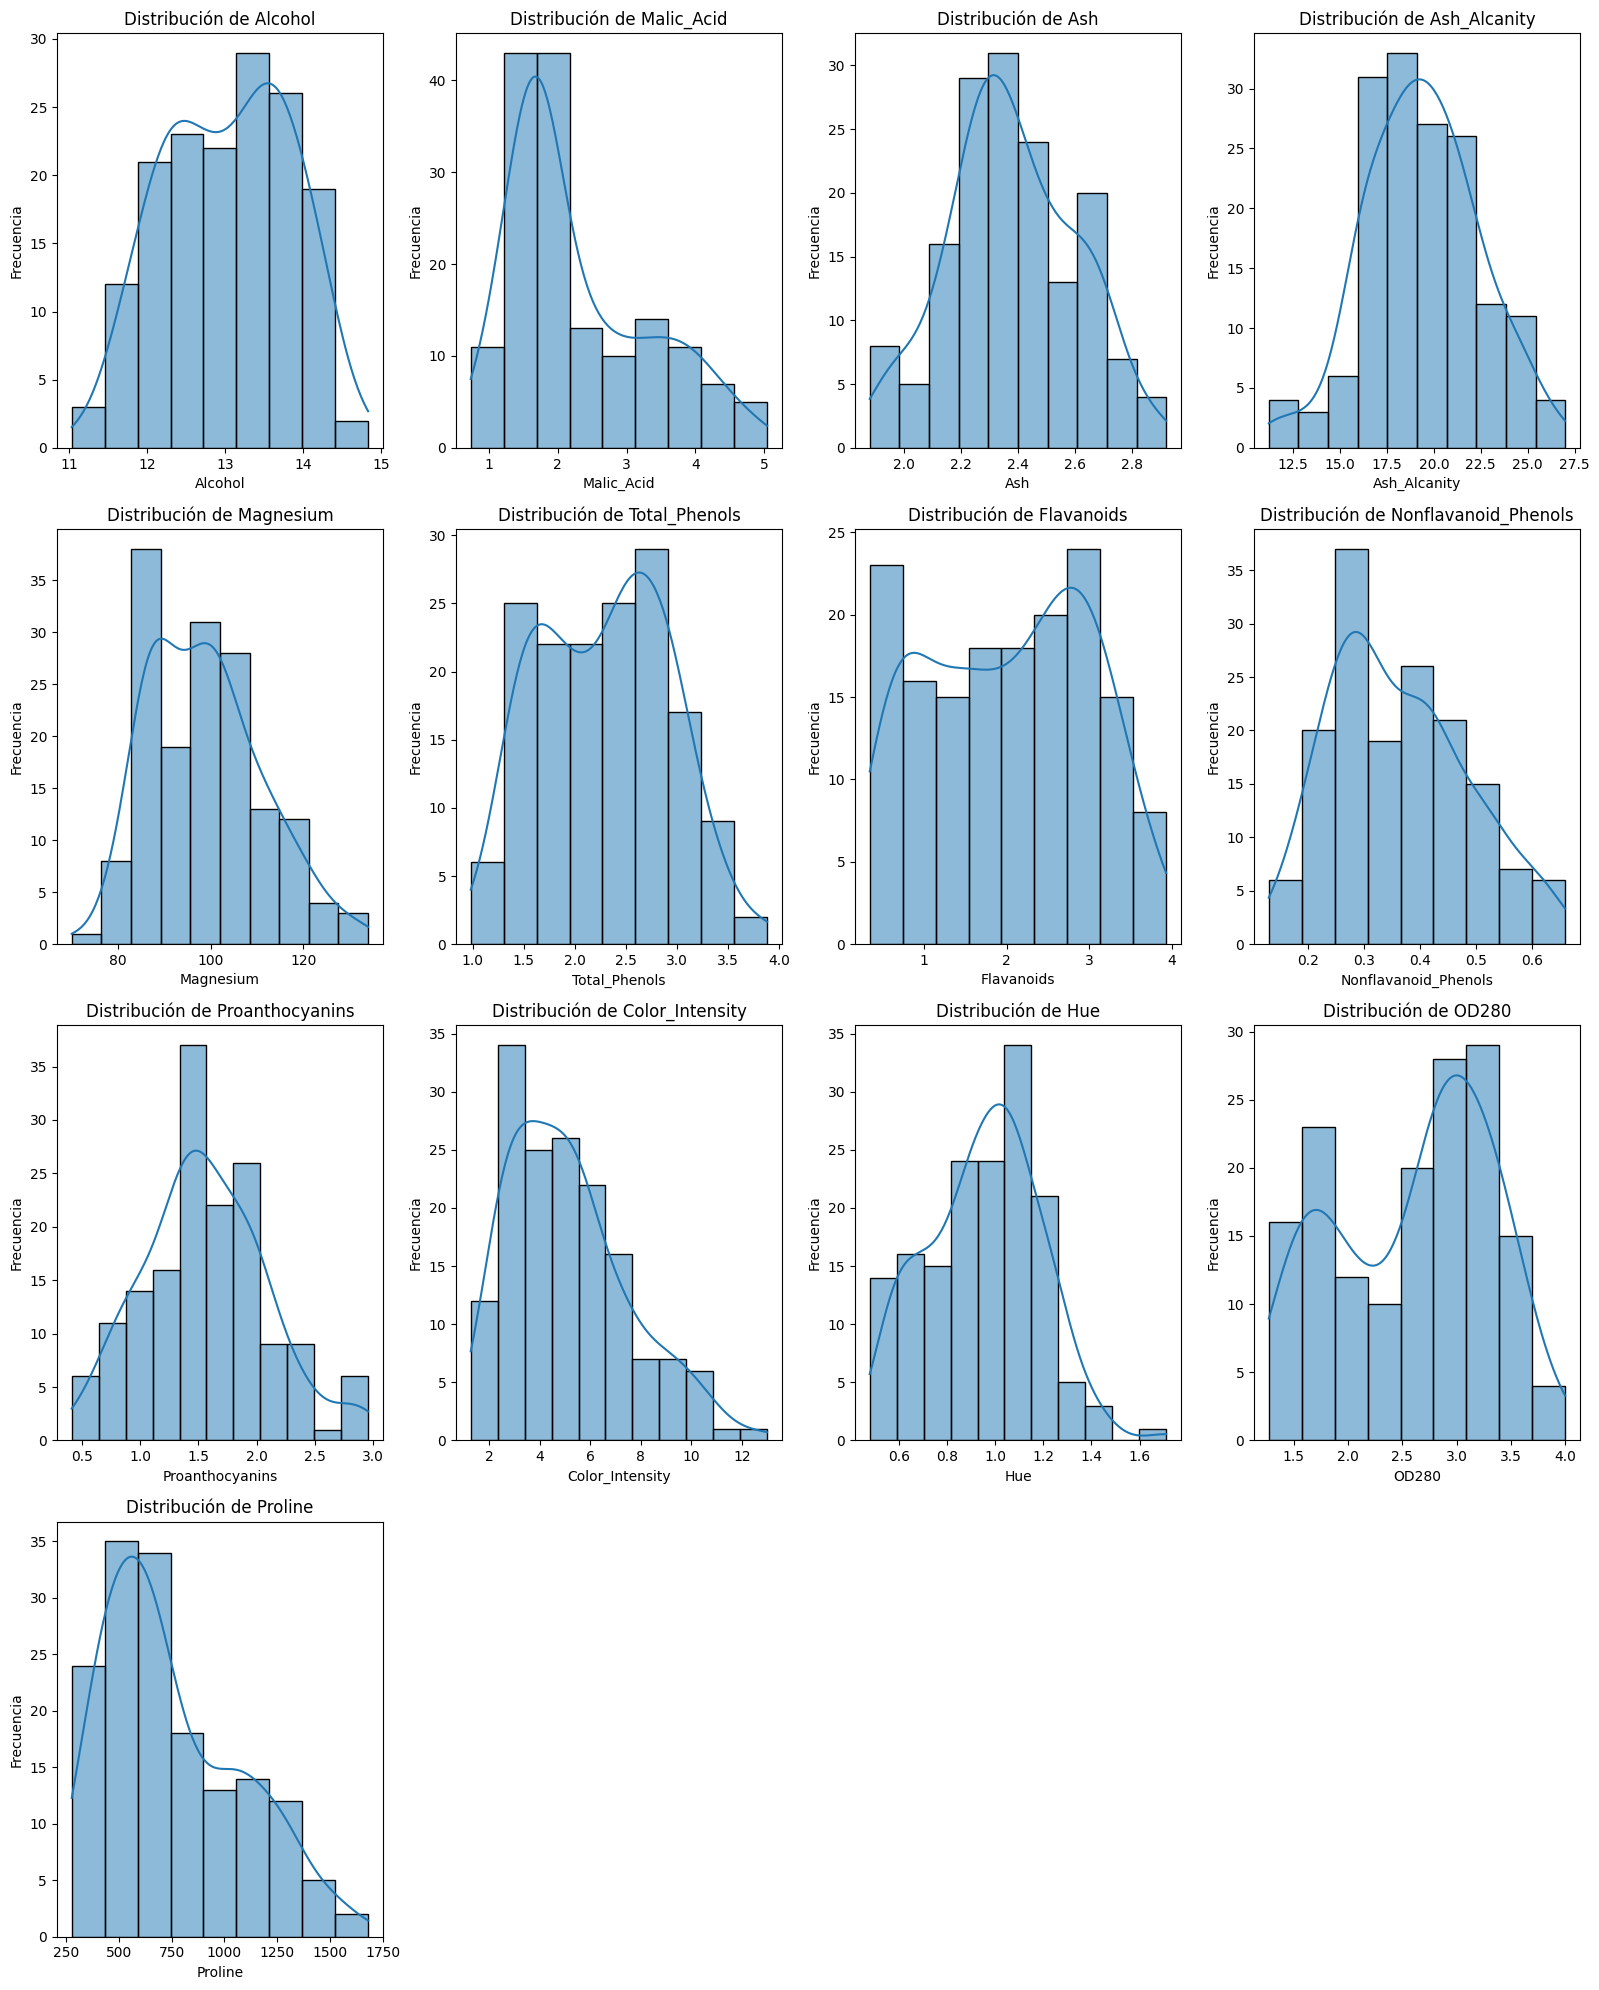

In [37]:
# Histogramas para variables tras el tratamiento de los outliers
num_columns = train_data_sin_outliers.columns

plt.figure(figsize=(16, 20))

for i, col in enumerate(num_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(train_data_sin_outliers[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()

plt.show()

In [38]:
# Calcular el skewness del DataFrame train_data_sin_outliers
skewness_train_sin_outliers = train_data_sin_outliers.skew()

# Imprimir los resultados
print("Skewness (Asimetría) del conjunto de entrenamiento (sin outliers):\n", skewness_train_sin_outliers)

Skewness (Asimetría) del conjunto de entrenamiento (sin outliers):
 Alcohol                -0.086283
Malic_Acid              0.898923
Ash                     0.064555
Ash_Alcanity           -0.016524
Magnesium               0.514922
Total_Phenols           0.088736
Flavanoids             -0.056338
Nonflavanoid_Phenols    0.430217
Proanthocyanins         0.322590
Color_Intensity         0.818413
Hue                     0.065882
OD280                  -0.282506
Proline                 0.731518
dtype: float64


####**8.2.1. Tratamiento del Skewness:**

Tras el tratamiento de los outliers del dataframe, se han identificado algunas variables con sesgos significativos hacia la derecha.

Para corregir el skewness, se aplicarán transformaciones logarítmicas y de raíz cuadrada. Las variables afectadas son:

  - **Malic_Acid (0.898923)**: Presenta una asimetría positiva considerable. La cola de la distribución se extiende hacia valores más altos.
  - **Magnesium (0.514922)**: Muestra una asimetría positiva moderada, aunque está cerca del límite superior de lo que se considera razonablemente simétrico.
  - **Nonflavanoid_Phenols (0.430217)**: También exhibe una asimetría positiva moderada, similar a Magnesium.
  - **Color_Intensity (0.818413)**: Tiene una asimetría positiva alta, similar a Malic_Acid, indicando una cola larga hacia valores más altos.
  - **Proline (0.731518)**: Muestra una asimetría positiva notable, con una cola que se extiende hacia valores más altos.

Para evaluar la efectividad de estas transformaciones, se compararán las métricas del skeweness y se visualizarán los histogramas de cada variable antes y después de la transformación.

Se seleccionará el método más adecuado en función de los resultados obtenidos.

In [39]:
# Hago copias del DataFrame para hacer pruebas y ver qué acción es mejor
train_data_log=train_data_sin_outliers.copy()           # Datos a utilizar en la transformacion logarítmica
train_data_raiz=train_data_sin_outliers.copy()          # Datos a utilizar en la transformación de raíz cuadrada

In [40]:
#Creo una función para realizar la Transformación logarítmica para las variables a tratar
def transformacion_logaritmica_y_eliminar(df):
    """
    Aplica una transformación logarítmica a las columnas a tratar del DataFrame.
    Se le suma 1 a cada valor antes de aplicar el logaritmo para evitar valores negativos o cero.
    Luego elimina las columnas originales.
    """
    # Aplicar la transformación logarítmica
    df['Malic_Acid_log'] = np.log(df['Malic_Acid'] + 1)
    df['Magnesium_log'] = np.log(df['Magnesium'] + 1)
    df['Nonflavanoid_Phenols_log'] = np.log(df['Nonflavanoid_Phenols'] + 1)
    df['Color_Intensity_log'] = np.log(df['Color_Intensity'] + 1)
    df['Proline_log'] = np.log(df['Proline'] + 1)

    # Eliminar las columnas originales
    df = df.drop(['Malic_Acid', 'Magnesium', 'Nonflavanoid_Phenols', 'Color_Intensity', 'Proline'], axis=1)

    return df

In [41]:
# Llamo a la función para transformar los datos de entrenamiento
train_data_log = transformacion_logaritmica_y_eliminar(train_data_log)

In [42]:
# Creo una función para realizar la Transformación de raíz cuadradada para las variables a tratar
def transformacion_raiz_y_eliminar(df):
    """
    Aplica una transformación de raíz cuadrada a las columnas a tratar del DataFrame.
    Luego elimina las columnas originales.
    """
    # Aplicar la transformación de raíz cuadrada
    df['Malic_Acid_sqrt'] = np.sqrt(df['Malic_Acid'] + 1)
    df['Magnesium_sqrt'] = np.sqrt(df['Magnesium'] + 1)
    df['Nonflavanoid_Phenols_sqrt'] = np.sqrt(df['Nonflavanoid_Phenols'] + 1)
    df['Color_Intensity_sqrt'] = np.sqrt(df['Color_Intensity'] + 1)
    df['Proline_sqrt'] = np.sqrt(df['Proline'] + 1)

    # Eliminar las columnas originales
    df = df.drop(['Malic_Acid', 'Magnesium', 'Nonflavanoid_Phenols', 'Color_Intensity', 'Proline'], axis=1)

    return df

In [43]:
# Llamo a la función para transformar los datos de entrenamiento
train_data_raiz = transformacion_raiz_y_eliminar(train_data_raiz)

Histogramas para visualizar las variables antes y después de los cambios.

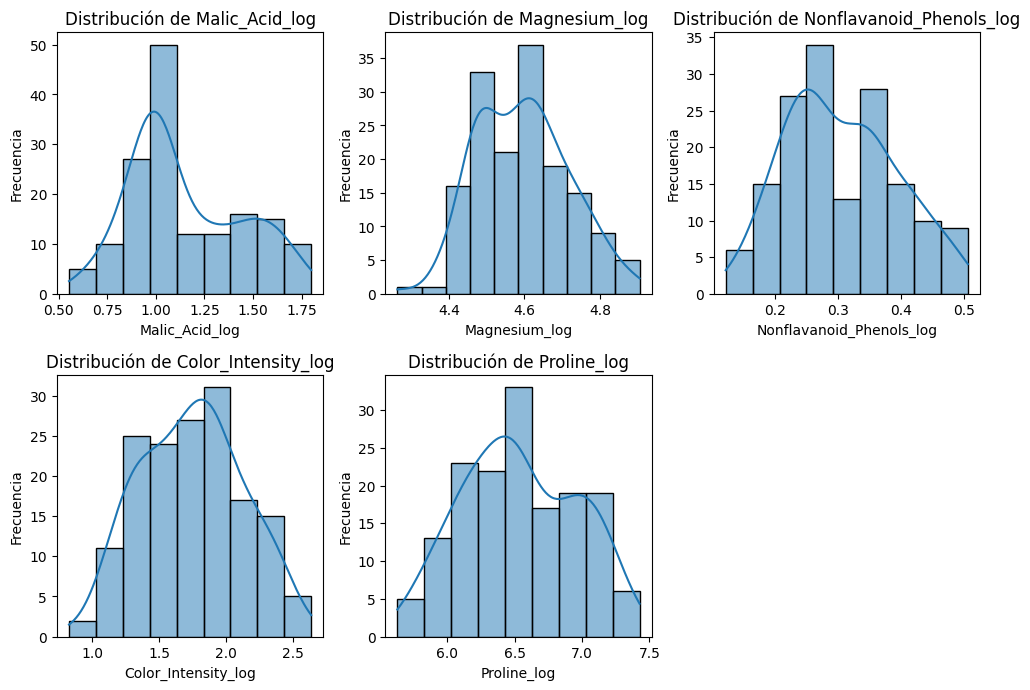

In [44]:
# Histogramas de las variables tratadas con Transformacion logarítmica
# Lista de columnas a visualizar
columnas_a_visualizar = [train_data_log.columns[8],  # Malic_Acid_log
                         train_data_log.columns[9],  # Magnesium_log
                         train_data_log.columns[10],  # Nonflavanoids_Phenols_log
                         train_data_log.columns[11],  # Color_Intensity_log
                         train_data_log.columns[12]  # Proline_log
                         ]

num_columnas_seleccionadas = len(columnas_a_visualizar)

plt.figure(figsize=(10, 2 * num_columnas_seleccionadas))
num_cols_subplot = num_columnas_seleccionadas // 3 + (num_columnas_seleccionadas % 3)
for i, col in enumerate(columnas_a_visualizar, 1):
    plt.subplot(3, num_cols_subplot, i)
    sns.histplot(train_data_log[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

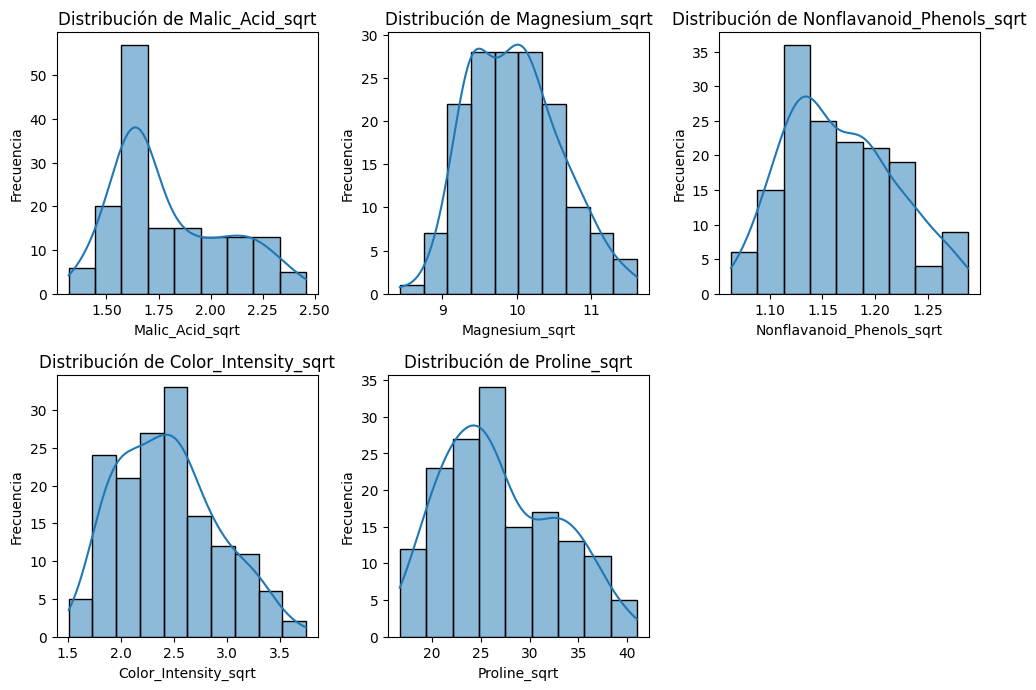

In [45]:
# Histogramas de las variables tratadas con Transformación raíz cuadrada
# Lista de columnas a visualizar
columnas_a_visualizar = [train_data_raiz.columns[8],  # Malic_Acid_sqrt
                         train_data_raiz.columns[9],  # Magnesium_sqrt
                         train_data_raiz.columns[10],  # Nonflavanoids_Phenols_sqrt
                         train_data_raiz.columns[11],  # Color_Intensity_sqrt
                         train_data_raiz.columns[12]  # Proline_sqrt
                         ]

num_columnas_seleccionadas = len(columnas_a_visualizar)

plt.figure(figsize=(10, 2 * num_columnas_seleccionadas))
num_cols_subplot = num_columnas_seleccionadas // 3 + (num_columnas_seleccionadas % 3)
for i, col in enumerate(columnas_a_visualizar, 1):
    plt.subplot(3, num_cols_subplot, i)
    sns.histplot(train_data_raiz[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [46]:
# Cálculo del skeweness después de realizar la transformación logarítmica
skewness_total_log = train_data_log.skew()
print("El skewness de todas las columnas numéricas es:\n", skewness_total_log)

El skewness de todas las columnas numéricas es:
 Alcohol                    -0.086283
Ash                         0.064555
Ash_Alcanity               -0.016524
Total_Phenols               0.088736
Flavanoids                 -0.056338
Proanthocyanins             0.322590
Hue                         0.065882
OD280                      -0.282506
Malic_Acid_log              0.489089
Magnesium_log               0.231305
Nonflavanoid_Phenols_log    0.268966
Color_Intensity_log         0.056022
Proline_log                 0.063317
dtype: float64


In [47]:
# Cálculo del skeweness después de realizar la transformación de raíz cuadrada
skewness_total_raiz = train_data_raiz.skew()
print("El skewness de todas las columnas numéricas es:\n", skewness_total_raiz)

El skewness de todas las columnas numéricas es:
 Alcohol                     -0.086283
Ash                          0.064555
Ash_Alcanity                -0.016524
Total_Phenols                0.088736
Flavanoids                  -0.056338
Proanthocyanins              0.322590
Hue                          0.065882
OD280                       -0.282506
Malic_Acid_sqrt              0.701059
Magnesium_sqrt               0.373302
Nonflavanoid_Phenols_sqrt    0.349610
Color_Intensity_sqrt         0.432961
Proline_sqrt                 0.407352
dtype: float64


####**8.2.2. Conclusiones de las transformaciones para disminuir el skeweness:**

Tras evaluar el impacto de distintas transformaciones (logarítmica y raíz cuadrada) en las variables a tratar, se ha determinado que la transformación logarítmica es la más adecuada para todas ellas. Esta elección se basa en su capacidad para reducir significativamente la desviación estándar y comprimir los datos, lo que indica una menor dispersión y una distribución más equilibrada.

La reducción de la desviación estándar sugiere que los datos transformados presentan menor variabilidad, lo que puede mejorar la estabilidad y la precisión de los modelos de aprendizaje automático. Además, la compresión de los datos ayuda a mitigar el impacto de valores atípicos y optimiza la eficiencia del modelo.

Por tanto se concluye que se aplicará la técnica de Transformación logarítmica para eliminar el sesgo de las variables:

  - Malic_Acid.
  - Magnesium.
  - Total_Phenols.
  - Flavanoids.
  - Nonflavanoid_Phenols.
  - Color_Intensity.
  - Proline.

####**8.2.3. Eliminación de características redundantes:**

In [48]:
def eliminar_variables_redundantes(df, umbral=0.7):
    corr_matrix = df.corr().abs()
    # Crear un conjunto para almacenar las columnas que se eliminarán
    columnas_a_eliminar = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > umbral:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                # Eliminar la columna con menor varianza
                var_col1 = df[col1].var()
                var_col2 = df[col2].var()
                if var_col1 < var_col2:
                    columnas_a_eliminar.add(col1)
                else:
                    columnas_a_eliminar.add(col2)

    df_reducido = df.drop(columns=list(columnas_a_eliminar))
    print(f"Variables eliminadas por alta correlación (>{umbral}): {list(columnas_a_eliminar)}")
    return df_reducido

# Aplicar a tu dataframe con tratamiento de valores atípicos y skewness
train_data_reducido = eliminar_variables_redundantes(train_data_log, umbral=0.7)

Variables eliminadas por alta correlación (>0.7): ['Proanthocyanins', 'OD280', 'Total_Phenols']


In [49]:
train_data_reducido.shape

(157, 10)

In [50]:
train_data_reducido.columns

Index(['Alcohol', 'Ash', 'Ash_Alcanity', 'Flavanoids', 'Hue', 'Malic_Acid_log',
       'Magnesium_log', 'Nonflavanoid_Phenols_log', 'Color_Intensity_log',
       'Proline_log'],
      dtype='object')

####**8.2.4. Estandarización / Normalización de variables numéricas:**

Los valores del conjunto de datos tienen rangos muy diferentes, lo que puede afectar negativamente el rendimiento de los algoritmos de aprendizaje automático que son sensibles a la escala.

Para minimizar estas diferencias y asegurar una escala uniforme en todo el conjunto de datos, se creará una función para aplicar la técnica de escalado StandardScaler de scikit-learn a todas las variables.

Los conjuntos de datos a los que se va a aplicar la normalización de variables son:

    - train_data_reducido

In [51]:
# Escalado de variables
from sklearn.preprocessing import StandardScaler

# Inicializar el StandardScaler
scaler = StandardScaler()

# Ajustar el scaler al conjunto de entrenamiento y transformar
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_data_reducido), columns=train_data_reducido.columns, index=train_data_reducido.index)

In [52]:
train_df_scaled.shape

(157, 10)

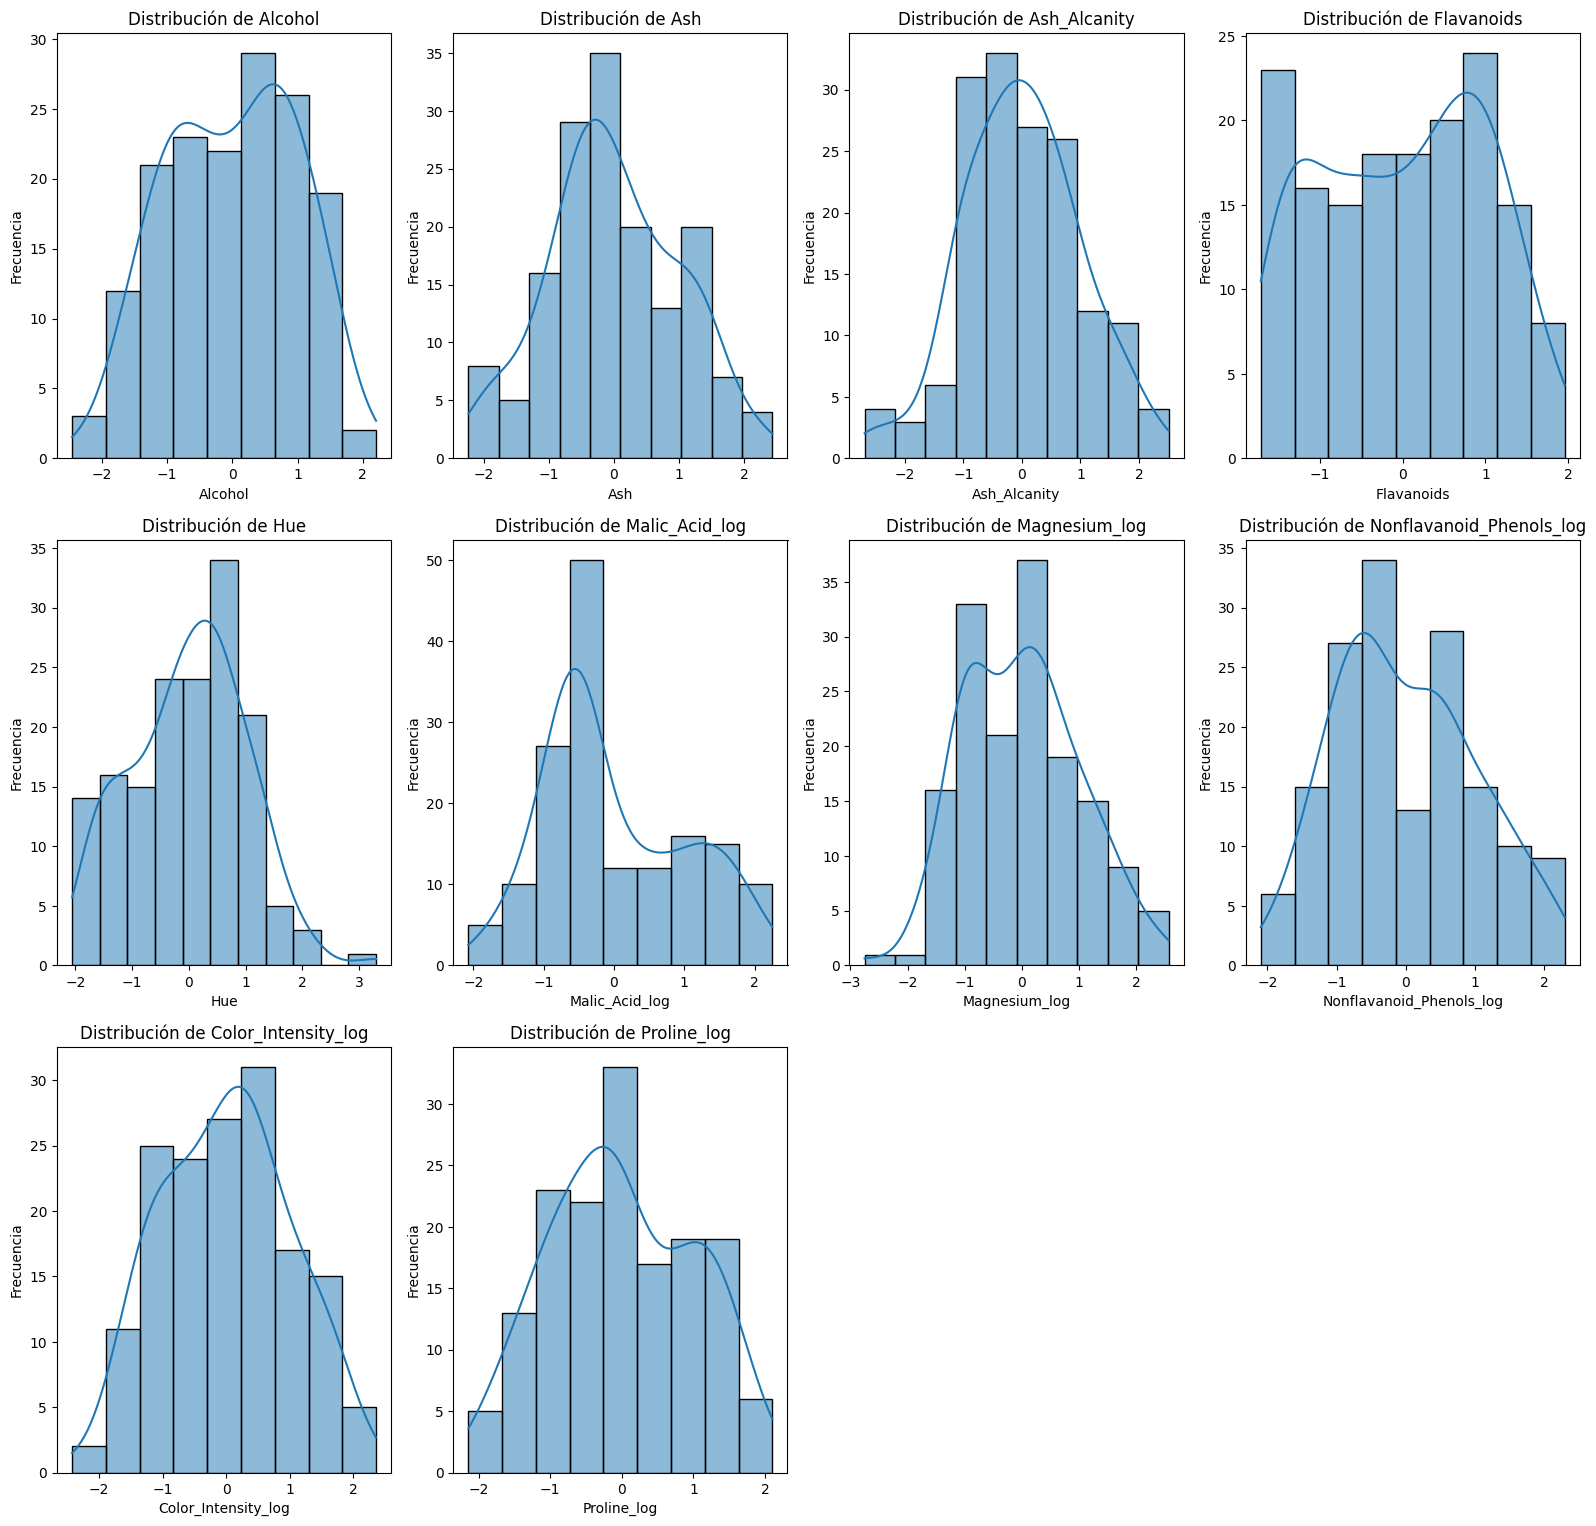

In [53]:
# Histogramas
num_columns = train_df_scaled.columns

plt.figure(figsize=(16, 20))

for i, col in enumerate(num_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(train_df_scaled[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()

plt.show()

##**9. Guardar los datos:**

In [54]:
import pickle

# Nombres de los archivos a guardar
nombre_archivo_train_pkl = 'train_df_scaled.pkl'

# Guardar los archivos
with open(nombre_archivo_train_pkl, 'wb') as archivo:
    pickle.dump(train_df_scaled, archivo)
    print(f"DataFrame train_df_scaled guardado correctamente en {nombre_archivo_train_pkl}")




DataFrame train_df_scaled guardado correctamente en train_df_scaled.pkl


In [55]:
# Guardar el Scaler
nombre_archivo_scaler = 'scaler.pkl'

# Guardar el objeto StandardScaler
with open(nombre_archivo_scaler, 'wb') as archivo:
    pickle.dump(scaler, archivo)

print(f"El objeto StandardScaler ha sido guardado exitosamente como '{nombre_archivo_scaler}' en la carpeta /content/ de Colab.")

El objeto StandardScaler ha sido guardado exitosamente como 'scaler.pkl' en la carpeta /content/ de Colab.
